# High throughput workflow example

iprPy handles calculation workflows in two stages:

1. Prepare creates multiple instances of a calculation both as input files and preliminary database entries.
2. Runner jobs then systematically run the calculations, update the database entries, and upload any generated calculation files into the database.

In [44]:
from pathlib import Path

import matplotlib.pyplot as plt

import atomman as am
import atomman.unitconvert as uc
import iprPy

import pandas as pd

## 1. Initial setup

Here, we'll create a testing "database", and populate it with input files from the public database.

In [38]:
# First, create a directory for running the calculations
run_directory = Path('.', 'run_directory')

if not Path(run_directory).exists():
    Path(run_directory).mkdir()

In [3]:
# Now specify a database location to use
database = iprPy.load_database(style='local', host='testing')

The iprPy databases have a "potdb" attribute, which will build the atomman-style database from the first Notebook.

In [6]:
potdb = database.potdb
print(potdb.remote_database)
print(potdb.local_database)

database style cdcs at https://potentials.nist.gov/
database style local at F:\atomman-demo\testing


Download all EAM potentials for Au

In [9]:
potdb.download_lammps_potentials(
    pair_style = ['eam', 'eam/alloy', 'eam/fs'],
    symbols = 'Au',
    downloadfiles = True,
    verbose = True
)

100%|██████████| 19/19 [00:00<00:00, 52.75it/s]


Found 19 matching potential_LAMMPS records in remote library
0 new records added to local
19 existing records skipped
34 existing parameter files skipped
Found 0 matching potential_LAMMPS_KIM records in remote library
0 new records added to local


Build the list of downloaded potentials

In [10]:
potential_LAMMPS_ids = database.get_records_df('potential_LAMMPS')['id'].tolist()
print(potential_LAMMPS_ids)

['1986--Foiles-S-M--Ag-Au-Cu-Ni-Pd-Pt--LAMMPS--ipr1', '1986--Foiles-S-M--Au--LAMMPS--ipr1', '1987--Ackland-G-J--Au--LAMMPS--ipr1', '1987--Ackland-G-J--Au--LAMMPS--ipr2', '1989--Adams-J-B--Ag-Au-Cu-Ni-Pd-Pt--LAMMPS--ipr1', '1989--Adams-J-B--Au--LAMMPS--ipr1', '1990--Ackland-G-J--Cu-Ag-Au--LAMMPS--ipr1', '2004--Zhou-X-W--Au--LAMMPS--ipr1', '2004--Zhou-X-W--Au--LAMMPS--ipr2', '2004--Zhou-X-W--Cu-Ag-Au--LAMMPS--ipr1', '2004--Zhou-X-W--Cu-Ag-Au--LAMMPS--ipr2', '2004--Zhou-X-W--Cu-Ag-Au-Ni-Pd-Pt-Al-Pb-Fe-Mo-Ta-W-Mg-Co-Ti-Zr--LAMMPS--ipr1', '2005--Grochola-G--Au--LAMMPS--ipr1', '2009--Zhakhovskii-V-V--Au--LAMMPS--ipr1', '2009--Zhakhovskii-V-V--Au--LAMMPS--ipr2', '2010--Olsson-P-A-T--Au--LAMMPS--ipr1', '2012--Norman-G-E--Au--LAMMPS--ipr1', '2017--OBrien-C-J--Pt-Au--LAMMPS--ipr1', '2017--Purja-Pun-G-P--Au--LAMMPS--ipr1']


Download all relaxed fcc crystals for the downloaded potentials

In [12]:
potdb.download_relaxed_crystals(
    method = 'dynamic',
    standing = 'good',
    family = 'A1--Cu--fcc',
    potential_LAMMPS_id = potential_LAMMPS_ids,
    symbols = 'Au',
    verbose = True
)

100%|██████████| 19/19 [00:01<00:00,  5.32it/s]

Found 19 matching relaxed_crystal records in remote library
19 new records added to local


## 2. Prepare relax_static calculations as a function of pressure

The prepare step is based on the input file variation of the individual calculation scripts.  In fact, prepare takes a similar input script with difference being that
- Keys can now have multiple values which can be specified by repeating the key with new values on new lines.
- The special buildcombos key can be used to call a pre-defined function that builds input values based on database entries.

In [13]:
calc = iprPy.load_calculation('relax_static')
print(calc.template)

# Input script for iprPy calculation relax_static

# Calculation Metadata
branch                          <branch>

# LAMMPS and MPI Commands
lammps_command                  <lammps_command>
mpi_command                     <mpi_command>

# Interatomic Potential
potential_file                  <potential_file>
potential_kim_id                <potential_kim_id>
potential_kim_potid             <potential_kim_potid>
potential_dir                   <potential_dir>

# Initial System Configuration
load_file                       <load_file>
load_style                      <load_style>
load_options                    <load_options>
family                          <family>
symbols                         <symbols>
box_parameters                  <box_parameters>

# System Manipulations
a_uvw                           <a_uvw>
b_uvw                           <b_uvw>
c_uvw                           <c_uvw>
atomshift                       <atomshift>
sizemults                       <sizemults>

# L

When prepare is called, you can pass in either the text key-value script or corresponding kwargs.  Here, we'll do the latter for simplicity.

In [ ]:
prepare_terms = {}

prepare_terms['lammps_command'] = 'lmp_serial'


# Use the atomicparent buildcombos function to generate potential and system info from the database
prepare_terms['buildcombos'] = 'atomicparent load_file parent'  # first term is type, second is an included key, third is name to assign to combo

# Modify combo using "parent_" keys
prepare_terms['parent_record'] = 'relaxed_crystal'
prepare_terms['parent_standing'] = 'good'
prepare_terms['parent_method'] = 'dynamic'

# Prepare limiters
prepare_terms['parent_potential_id'] = '2009--Zhakhovskii-V-V--Au--LAMMPS--ipr2'  # use only this potential
prepare_terms['parent_family'] = 'A1--Cu--fcc'
prepare_terms['parent_composition'] = 'Au'

# List pressures to evaluate
pressures = [
    '0 GPa',
    '10 GPa',
    '20 GPa',
    '30 GPa',
    '40 GPa',
    '50 GPa',
    '60 GPa',
    '70 GPa',
    '80 GPa',
    '90 GPa',
    '100 GPa'    
]
prepare_terms['pressure_xx'] = prepare_terms['pressure_yy'] = prepare_terms['pressure_zz'] = pressures



Now we prepare!

In [24]:
database.prepare(run_directory, calc, **prepare_terms)

0 existing calculation records found
1 matching interatomic potentials found
1 matching atomic parents found


100%|██████████| 11/11 [00:00<00:00, 20.42it/s]

11 calculation combinations to check
11 new records to prepare



preparing: 100%|##########| 11/11 [00:02<00:00,  5.04it/s]


['7d8f4915-bb3c-49ad-8854-fdcecb43be8d',
 '22eba793-19e9-4378-905a-068bbe372e82',
 '2896a832-8ca1-4c4f-9a53-e920b2d9f3e2',
 '0c165837-99f2-4acc-85e2-c8cd623c8ef9',
 '381b79d2-279a-42b3-b0c2-2bbcb5f64fd5',
 'a0045dce-f690-44be-8124-f35e73fc08db',
 '6b992997-c3db-44f4-b204-bc9cd43576fb',
 '616672e8-9676-4913-a480-67bf64db3ccf',
 '6c2bd979-4c22-45bf-b469-cc03931b9815',
 '6a839f51-8707-4af1-88fe-964558e2600e',
 'acb879ee-c7ec-451c-9dca-2c771c62523a']

# 3. Run

You can start runners either from within Python using Database.runner()

If you've saved the database and run_directory info, you can start runners from the command line with
    
    iprPy runner {database_name} {run_directory_name}
    
Multiple runners can operate simultaneously without conflict, and can be assigned any number of cores to work with.

In [25]:
database.runner(run_directory)

Runner started with pid 18312
381b79d2-279a-42b3-b0c2-2bbcb5f64fd5
sim calculated successfully

acb879ee-c7ec-451c-9dca-2c771c62523a
sim calculated successfully

616672e8-9676-4913-a480-67bf64db3ccf
sim calculated successfully

6a839f51-8707-4af1-88fe-964558e2600e
sim calculated successfully

22eba793-19e9-4378-905a-068bbe372e82
sim calculated successfully

6b992997-c3db-44f4-b204-bc9cd43576fb
sim calculated successfully

6c2bd979-4c22-45bf-b469-cc03931b9815
sim calculated successfully

0c165837-99f2-4acc-85e2-c8cd623c8ef9
sim calculated successfully

2896a832-8ca1-4c4f-9a53-e920b2d9f3e2
sim calculated successfully

7d8f4915-bb3c-49ad-8854-fdcecb43be8d
sim calculated successfully

a0045dce-f690-44be-8124-f35e73fc08db
sim calculated successfully

No simulations left to run


# 4. Analyze

In [41]:
relaxes, relaxes_df = database.get_records('calculation_relax_static',
                                           potential_LAMMPS_id = '2009--Zhakhovskii-V-V--Au--LAMMPS--ipr2',
                                           status = 'finished',
                                           return_df = True)

In [30]:
relaxes_df.keys()

Index(['name', 'key', 'url', 'iprPy_version', 'atomman_version', 'script',
       'branch', 'status', 'lammps_version', 'potential_LAMMPS_key',
       'potential_LAMMPS_id', 'potential_LAMMPS_url', 'potential_key',
       'potential_id', 'potential_url', 'load_file', 'load_style',
       'load_options', 'parent_key', 'family', 'family_url', 'symbols',
       'composition', 'a_mult1', 'a_mult2', 'b_mult1', 'b_mult2', 'c_mult1',
       'c_mult2', 'atomshift', 'a_uvw', 'b_uvw', 'c_uvw', 'energytolerance',
       'forcetolerance', 'maxiterations', 'maxevaluations', 'maxatommotion',
       'temperature', 'pressure_xx', 'pressure_yy', 'pressure_zz',
       'pressure_xy', 'pressure_xz', 'pressure_yz', 'lx', 'ly', 'lz', 'xy',
       'xz', 'yz', 'E_pot', 'measured_temperature', 'measured_pressure_xx',
       'measured_pressure_yy', 'measured_pressure_zz', 'measured_pressure_xy',
       'measured_pressure_xz', 'measured_pressure_yz'],
      dtype='object')

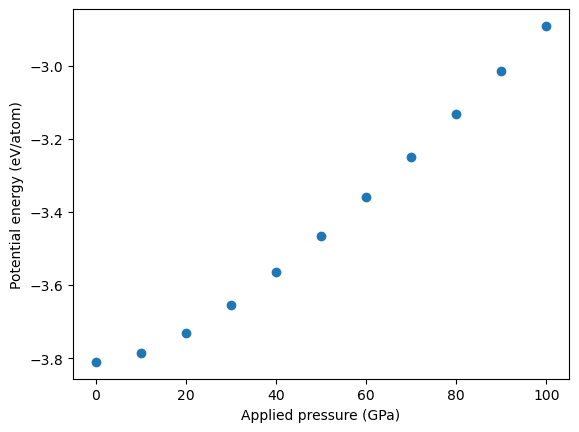

In [53]:
plt.plot(uc.get_in_units(relaxes_df.pressure_xx, 'GPa'), 
         uc.get_in_units(relaxes_df.E_pot, 'eV'), 'o')
plt.xlabel('Applied pressure (GPa)')
plt.ylabel('Potential energy (eV/atom)')
plt.show()

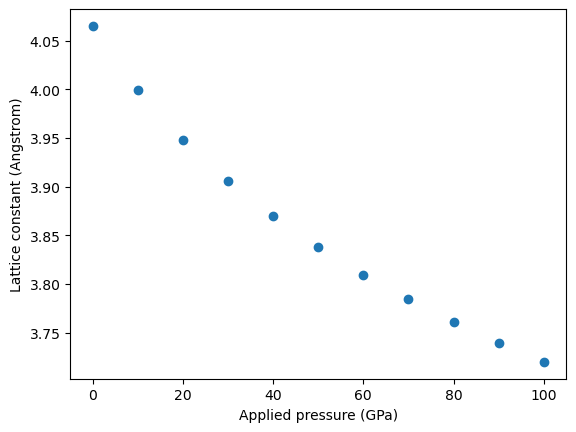

In [54]:
plt.plot(uc.get_in_units(relaxes_df.pressure_xx, 'GPa'), 
         uc.get_in_units(relaxes_df.lx, 'eV'), 'o')

plt.xlabel('Applied pressure (GPa)')
plt.ylabel('Lattice constant (Angstrom)')
plt.show()

## 5. Now, do elastic constants...

In [35]:
calc = iprPy.load_calculation('elastic_constants_static')

In [36]:
prepare_terms = {}

prepare_terms['lammps_command'] = 'lmp_serial'


# Use the atomicarchive buildcombos function to pull final configurations from relax_static results
prepare_terms['buildcombos'] = 'atomicarchive load_file parent'  # first term is type, second is an included key, third is name to assign to combo

# Modify combo using "parent_" keys
prepare_terms['parent_record'] = 'calculation_relax_static'
prepare_terms['parent_load_key'] = 'final-system'
prepare_terms['parent_status'] = 'finished'

# Prepare limiters
prepare_terms['parent_potential_id'] = '2009--Zhakhovskii-V-V--Au--LAMMPS--ipr2'  # use only this potential
prepare_terms['parent_family'] = 'A1--Cu--fcc'
prepare_terms['parent_composition'] = 'Au'

In [39]:
database.prepare(run_directory, calc, **prepare_terms)

0 existing calculation records found
1 matching interatomic potentials found
11 matching atomic archives found


100%|██████████| 11/11 [00:00<00:00, 21.21it/s]

11 calculation combinations to check
11 new records to prepare



preparing: 100%|##########| 11/11 [00:03<00:00,  3.15it/s]


['4e53ed8b-3019-4b27-9b6e-416cd48620ff',
 '0c9802ea-23b6-4a04-8328-2acc7779eaf3',
 '06ce3db3-e86d-4907-8367-5883b6594028',
 '82b321b9-bbf0-4f35-985b-c13272df8c4a',
 '73afb74e-016b-43fc-83a5-9468309b98b3',
 '8a06127b-5d3f-4ec4-8e80-757cda68ac05',
 '0417d501-8b09-4643-9f61-6cdcad304f07',
 '1d911982-ee6f-428c-8535-0fa57507dad2',
 '79f59aa4-18f9-46f2-a690-776b5b05c1d5',
 '0c2f7440-9bd8-477a-aad4-659bf6c4b07b',
 'ab540fad-1632-4b5b-a7b4-0116f5d200d5']

In [40]:
database.runner(run_directory)

Runner started with pid 18312
79f59aa4-18f9-46f2-a690-776b5b05c1d5
sim calculated successfully

1d911982-ee6f-428c-8535-0fa57507dad2
sim calculated successfully

8a06127b-5d3f-4ec4-8e80-757cda68ac05
sim calculated successfully

73afb74e-016b-43fc-83a5-9468309b98b3
sim calculated successfully

4e53ed8b-3019-4b27-9b6e-416cd48620ff
sim calculated successfully

82b321b9-bbf0-4f35-985b-c13272df8c4a
sim calculated successfully

0417d501-8b09-4643-9f61-6cdcad304f07
sim calculated successfully

0c2f7440-9bd8-477a-aad4-659bf6c4b07b
sim calculated successfully

06ce3db3-e86d-4907-8367-5883b6594028
sim calculated successfully

0c9802ea-23b6-4a04-8328-2acc7779eaf3
sim calculated successfully

ab540fad-1632-4b5b-a7b4-0116f5d200d5
sim calculated successfully

No simulations left to run


In [42]:
cijs, cijs_df = database.get_records('calculation_elastic_constants_static',
                                     potential_LAMMPS_id = '2009--Zhakhovskii-V-V--Au--LAMMPS--ipr2',
                                     status = 'finished',
                                     return_df = True)

In [43]:
cijs_df.keys()

Index(['name', 'key', 'url', 'iprPy_version', 'atomman_version', 'script',
       'branch', 'status', 'lammps_version', 'potential_LAMMPS_key',
       'potential_LAMMPS_id', 'potential_LAMMPS_url', 'potential_key',
       'potential_id', 'potential_url', 'load_file', 'load_style',
       'load_options', 'parent_key', 'family', 'family_url', 'symbols',
       'composition', 'a_mult1', 'a_mult2', 'b_mult1', 'b_mult2', 'c_mult1',
       'c_mult2', 'atomshift', 'a_uvw', 'b_uvw', 'c_uvw', 'energytolerance',
       'forcetolerance', 'maxiterations', 'maxevaluations', 'maxatommotion',
       'strainrange', 'C', 'raw_Cij_negative', 'raw_Cij_positive'],
      dtype='object')

In [48]:
def extract_C11_GPa(series):
    return(uc.get_in_units(series.C.Cij[0,0], 'GPa'))
def extract_C12_GPa(series):
    return(uc.get_in_units(series.C.Cij[0,1], 'GPa'))
def extract_C44_GPa(series):
    return(uc.get_in_units(series.C.Cij[3,3], 'GPa'))

cijs_df['C11'] = cijs_df.apply(extract_C11_GPa, axis=1)
cijs_df['C12'] = cijs_df.apply(extract_C12_GPa, axis=1)
cijs_df['C44'] = cijs_df.apply(extract_C44_GPa, axis=1)

Now, we have a slight issue as the elastic constant calculations do not contain pressure information.  However, they do have a 'parent_key' which corresponds to the relax_static record that it was based on.

In [49]:
merged_df = pd.merge(relaxes_df, cijs_df, left_on='key', right_on='parent_key')

In [50]:
merged_df.keys()

Index(['name_x', 'key_x', 'url_x', 'iprPy_version_x', 'atomman_version_x',
       'script_x', 'branch_x', 'status_x', 'lammps_version_x',
       'potential_LAMMPS_key_x',
       ...
       'maxiterations_y', 'maxevaluations_y', 'maxatommotion_y', 'strainrange',
       'C', 'raw_Cij_negative', 'raw_Cij_positive', 'C11', 'C12', 'C44'],
      dtype='object', length=104)

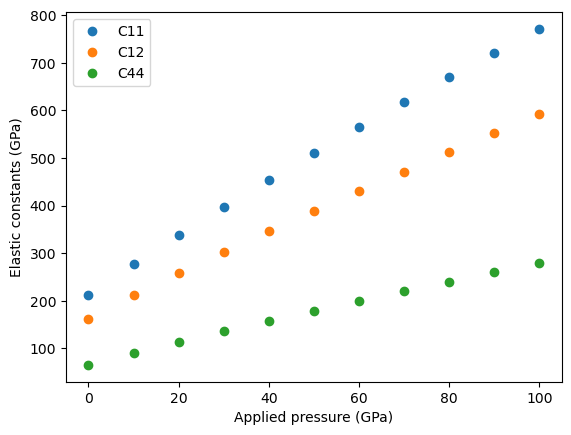

In [52]:
plt.plot(uc.get_in_units(merged_df.pressure_xx, 'GPa'), merged_df.C11, 'o', label='C11') 
plt.plot(uc.get_in_units(merged_df.pressure_xx, 'GPa'), merged_df.C12, 'o', label='C12')
plt.plot(uc.get_in_units(merged_df.pressure_xx, 'GPa'), merged_df.C44, 'o', label='C44')

plt.xlabel('Applied pressure (GPa)')
plt.ylabel('Elastic constants (GPa)')
plt.legend()
plt.show()